# Matrix Completion, part 1

This lab is a precursor to the "big" lab we'll do next week on matrix completion.  You will build much of the infrastructure for this assignment this week.  We will use our very small foods dataset to make sure all our code runs properly.  In some ways, this dataset is perfect for development - it is small, so our code will run fast, and the matrix is quite dense - that is, there aren't many missing data points.

Begin by running the below to create your `foodMatrix` matrix you'll be completing.  Note you'll have both `foodFrame` which is the pandas dataframe and `foodMatrix` which is the numpy array.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [5]:
df = pd.read_csv('../datasets/foodsAndMovies.csv')
foodFrame = df[['Broccoli', 'Mushrooms', 'Beef Tacos', 'Salads', 'Black Licorice', 'Steak', 'Grilled Chicken', 'Mayonnaise', 'Candy Corn', 'Pulled Pork', 'Spicy Mustard', 'Raw Oysters', 'Bananas', 'Avocado', 'Eggs', 'Olives', 'Tofu', 'Cottage Cheese']]
foodMatrix=foodFrame.values
print(foodMatrix.shape)

(603, 18)


We need to know which indices have nans, and which do not.  Write a function which takes in a matrix like `foodMatrix` and returns a list of tuples containing the rows and columns of a rating.  That is, if your function is called on `foodMatrix`, it *should* contain `(0,0)` but should *not* contain `(2,17)`. This is because 0,0 is rated (with 4 stars) and 2,17 is not (it's a NaN).

You may use generative AI for this portion, and all portions until stated otherwise.

In [3]:
def findRatings(mat):
    indeces = []
    numRows, numCols = mat.shape
    for row in range(numRows):
        for col in range(numCols):
            if not np.isnan(mat[row][col]):
                indeces.append((row, col))
    return indeces

Run your function on `foodMatrix` and use sklearn's function `train_test_split()` to split the list into a training set of indices and a testing set.

In [5]:
totalIndeces = findRatings(foodMatrix)
train, test = train_test_split(totalIndeces, test_size=0.1)

We will need an error function so we can tell if our completion is working. We'll use root mean squared error (RMSE), which is defined as: 

$$\sqrt{\frac{\sum_{(i,j)\in T}(\text{original}[i,j]-\text{reproduction}[i,j])^2}{|T|}}$$

where $T$ is a set of indices, `original` is the original matrix, and `reproduction` is your value from the completed matrix.

Your function should take three arguments, the original matrix, the reproduction, and a set of indices (like your training or testing sets you created above).  Test your function with some quick sanity checks - if you call it with the same matrix for original and reproduction, do you get back 0?  If you very slightly change a value in the reproduction which appears in the index set, do you get back a non-zero but small value?

In [6]:
def rmse(org, rep, indeces):
    sum = 0
    for row, col in indeces:
        diff = org[row][col] - rep[row][col]
        sum += diff * diff
    return np.sqrt(sum/len(indeces))



# using same matrix, should get 0
print(f"Same matrix error: {rmse(foodMatrix, foodMatrix, train)}")

# using slightly altered matrix, should get very small error
newMatrix = deepcopy(foodMatrix)
newMatrix[0][0] = 1
print(f"Altered matrix error: {rmse(foodMatrix, newMatrix, train)}")

Same matrix error: 0.0
Altered matrix error: 0.03079394062236661


We need to make our initial guesses of $P$ and $Q$.  Write a function which takes in a matrix's size and assumed rank, and creates appropriate $P$ and $Q$.  A danger here is if you use large values, `P@Q` will overflow, so start with small, random values close to zero.

In [7]:
# returns (P, Q)
def createPQ(dimension, rank):
    return (np.square(np.random.rand(dimension[0], rank)-0.5), np.square(np.random.rand(rank, dimension[1])-0.5))

P, Q = createPQ(foodMatrix.shape, 10)

It's business time.  Make a function called `epoch`, which runs one epoch of training.  It should accept your original matrix, your current values of $P$ and $Q$, a stepsize, a training set of indices and a testing set of indices.  It should train on all elements of the training set, then calculate the training and testing errors.  It should return the updated matrices $P$, $Q$, and the scalars of the training and testing errors.

You may **NOT** use generative AI on this portion.  You may not use functions from other libraries that purport to perform matrix completion.

In [9]:
# returns (P, Q, training error, testing error)
def epoch(original, fP, fQ, a, fTrain, fTest):

    # train on elements from training set
    fQ = fQ.T
    for i, j in fTrain:
        gradient = foodMatrix[i][j] - np.dot(fP[i], fQ[j])
        fP[i], fQ[j] = fP[i] + a*fQ[j]*gradient, fQ[j] + a*fP[i]*gradient
    fQ = fQ.T

    # return P, Q, training error and testing error
    reconstruction = fP @ fQ
    return (fP, fQ, rmse(original, reconstruction, fTrain), rmse(original, reconstruction, fTest))

Now you have everything you need.  Choose some assumed rank, stepsize, and number of epochs, and run matrix completion.  Keep lists of the training and testing errors after each epoch.  You may **NOT** use generative AI on this portion.

In [10]:
def matrixCompletion(original, fP, fQ, rank, stepSize, numEpochs):

    # run matrix completion, keep track of error
    trainErrors, testErrors = [], []
    for i in range(numEpochs):
        fP, fQ, trainE, testE = epoch(original, fP, fQ, stepSize, train, test)
        trainErrors.append(trainE)
        testErrors.append(testE)

    # plot error
    plt.plot(range(len(trainErrors)), trainErrors, label='Training Error')
    plt.plot(range(len(testErrors)), testErrors, label='Testing Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

Plot your training and testing errors as a function of the epoch. You **may** use generative AI on this portion.

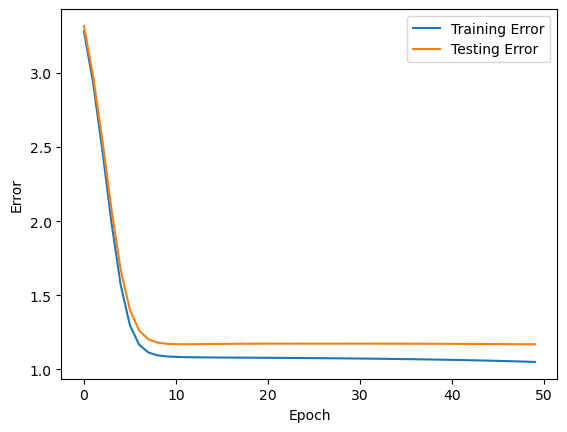

In [28]:
matrixCompletion(foodMatrix, deepcopy(P), deepcopy(Q), 10, 0.001, 50)

Play around with the stepsize, rank, and number of epochs.  Below, answer a couple questions, by running experiments and showing me error plots that support your argument.

- What happened when your stepsize was too small? Too large?
- Relate the value of rank to bias and variance.  What would cause high bias and low variance?  What about low bias and high variance?
- Is more epochs always better?

You may **NOT** use generative AI on this portion.

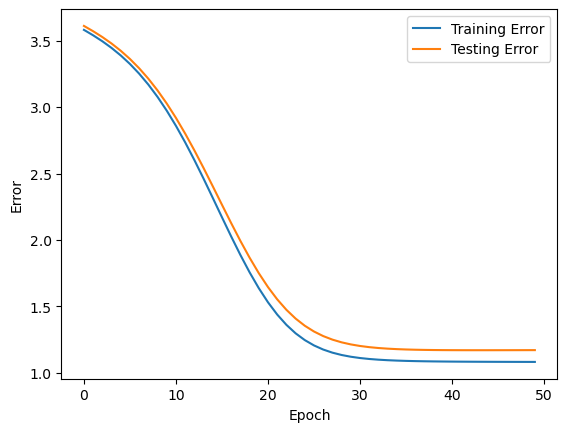

In [14]:
# small step size
matrixCompletion(foodMatrix, deepcopy(P), deepcopy(Q), 10, 0.0003, 50)

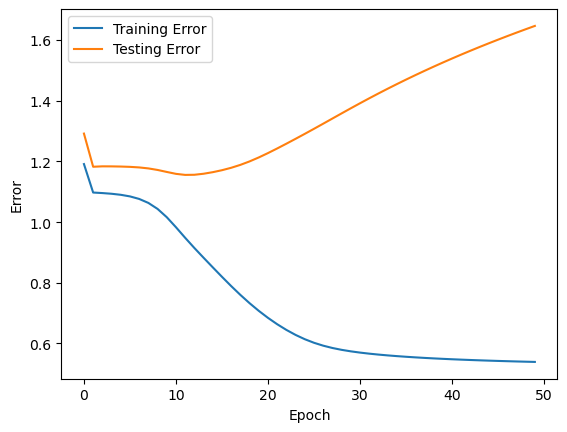

In [15]:
# big step size
matrixCompletion(foodMatrix, deepcopy(P), deepcopy(Q), 10, 0.008, 50)

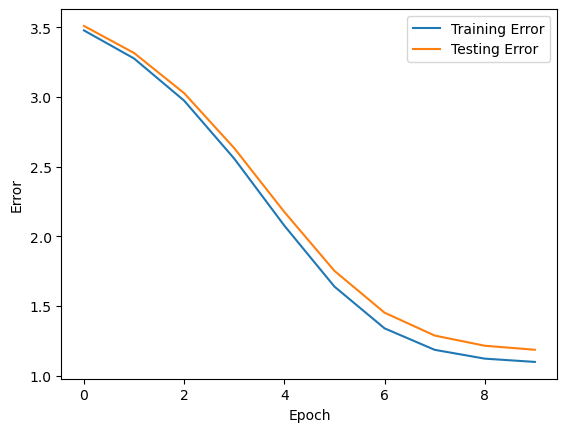

In [17]:
# fewer epochs
matrixCompletion(foodMatrix, deepcopy(P), deepcopy(Q), 10, 0.001, 10)

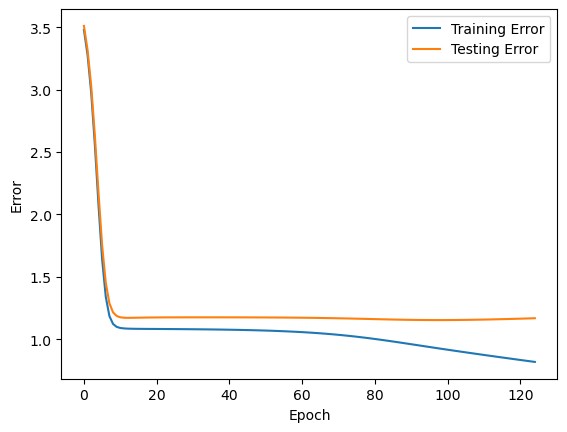

In [18]:
# more epochs
matrixCompletion(foodMatrix, deepcopy(P), deepcopy(Q), 10, 0.001, 125)

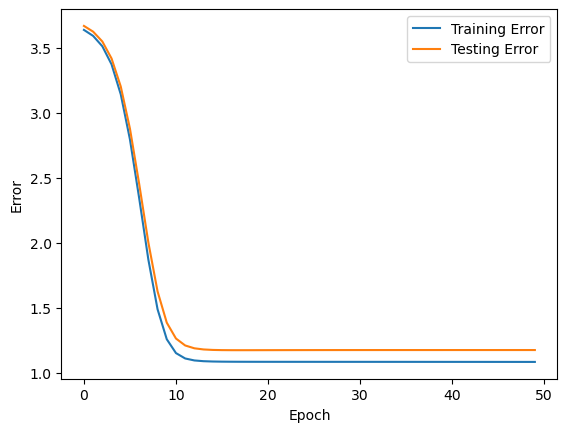

In [19]:
# lower rank
P, Q = createPQ(foodMatrix.shape, 2)
matrixCompletion(foodMatrix, deepcopy(P), deepcopy(Q), 2, 0.001, 50)

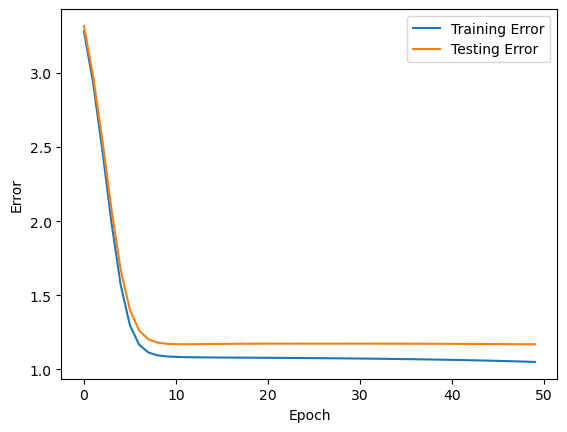

In [20]:
# higher rank
P, Q = createPQ(foodMatrix.shape, 20)
matrixCompletion(foodMatrix, deepcopy(P), deepcopy(Q), 20, 0.001, 50)

### Answers
* When the stepsize was too small, the error started much higher and didn't get as low as the matrix completion with a bigger stepsize. However, when the stepsize was too large, the testing error quickly started to grow instead of shrink, which told me that the SGD may have been being too stochastic and jumping over minimums with a bigger step size.
* A smaller rank means higher bias and lower variance. Bigger rank means lower bias and higher variance. I couldn't really tell a difference in the graphs, but ultimately after looking into what bias and variance were, I was able to deduce the relationships between them.
* More epochs may not always be better, as overfitting may occur. In the graph, the testing error begins to rise as more epochs are run.

### Corrections
* I changed the hyperparameters after seeing the class example - I lowered the step size and number of epochs for all cases.
* Also, I changed some of the explanations for my answers, because the trials had different results after changing the values.